# Preliminary Operations
## Imports

In [1]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import argparse
# import sys
from pathlib import Path
import scipy.io as sio
import imageio
import cv2
from time import perf_counter



from IPython.display import HTML, display
import tabulate
import os
import warnings

# sys.path.append('../..');
from spyrit.learning.model_Had_DCAN import *
from spyrit.learning.nets import *
from spyrit.misc.disp import *
from spyrit.misc.metrics import *
from spyrit.reconstruction.recon_functions import * 

plt.rcParams['figure.figsize'] = [20, 10]
torch.manual_seed(19)

In [2]:
from scipy.sparse.linalg import aslinearoperator
import pylops

def TV(y, H, img_size, mu = 0.15, lamda = [0.1, 0.1], niter = 20, niterinner = 10):
    ny = img_size;
    nx = img_size;
    A = aslinearoperator(H);
    H_p = pylops.LinearOperator(A)
    Dop = \
        [pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=0, edge=False,
                                kind='backward', dtype=np.float64),
         pylops.FirstDerivative(ny * nx, dims=(ny, nx), dir=1, edge=False,
                                kind='backward', dtype=np.float64)]
    xinv, niter = \
    pylops.optimization.sparsity.SplitBregman(H_p, Dop, y.flatten(),
                                              niter, niterinner,
                                              mu=mu, epsRL1s=lamda,
                                              tol=1e-4, tau=1., show=False,
                                              **dict(iter_lim=5, damp=1e-4))
    return xinv;

def batch_TV(m, batch_size, ch, img_size, H,N_0, mu = 0.15, lamda = [0.001, 0.001], niter = 20, niterinner = 10):
    outputs = np.zeros((batch_size*ch, 1, img_size, img_size));
    M = H.shape[0];
    even_indices = range(0,2*M,2);
    uneven_index = range(1,2*M,2);
    for i in range(batch_size*ch):
        m_i = torch2numpy(m[i,0,:]);
        m_i = m_i[even_indices]-m_i[uneven_index];
        out = TV(m_i, H, img_size, mu, lamda, niter, niterinner)
        outputs[i, 0, :,:] = 2/N_0*np.reshape(out, (img_size, img_size))-1;
    output_batch  = torch.Tensor(outputs);
    return output_batch;


## Parameters
### Acquisition Parameters

In [3]:
img_size = 64;

### Network and training

In [4]:
data_root = "../../data/" # Path to SLT-10 dataset
precompute_root ="../../models/SDCAN/"# Path to precomputed data
precompute =  False # Tells if the precomputed data is available 
n_iter = 5;

### Experimental Data

In [5]:
expe_root = "../../data/expe_2/" # Path to precomputed data

### Optimisation

In [6]:
num_epochs = 20 ; #Number of training epochs 
batch_size = 8; # Size of each training batch
reg = 1e-7; # Regularisation Parameter
lr = 1e-3; # Learning Rate
step_size = 4; #Scheduler Step Size
gamma =0.5; # Scheduler Decrease Rate

## Loading Pre-processed Data

In [7]:
my_average_file = Path(precompute_root) / ('Average_{}x{}'.format(img_size, img_size)+'.npy')
my_cov_file = Path(precompute_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.npy')

Path(precompute_root).mkdir(parents=True, exist_ok=True)
if not(my_average_file.is_file()) or not(my_cov_file.is_file()) or precompute:
    print('Computing covariance and mean (overwrite previous files)')
    Mean_had, Cov_had = Stat_had(trainloader, precompute_root)
else:
    print('Loading covariance and mean')
    Mean_had = np.load(my_average_file)
    Cov_had  = np.load(my_cov_file)

if expe_root:
    my_transform_file = Path(expe_root) / ('transform_{}x{}'.format(img_size, img_size)+'.mat')
    H = sio.loadmat(my_transform_file);
    H = (1/img_size)*H["H"]

    my_average_file = Path(expe_root) / ('Average_{}x{}'.format(img_size, img_size)+'.mat')
    my_cov_file = Path(expe_root) / ('Cov_{}x{}'.format(img_size, img_size)+'.mat')
    Mean_had_1 = sio.loadmat(my_average_file)
    Cov_had_1  = sio.loadmat(my_cov_file)

    Mean_had_1 = Mean_had_1["mu"]-np.dot(H, np.ones((img_size**2,1)));
    Mean_had_1 = np.reshape(Mean_had_1,(img_size, img_size));
    Mean_had_1 = np.amax(Mean_had)/np.amax(Mean_had_1)*Mean_had_1;
    Cov_had_1 = Cov_had_1["C"];
    Cov_had_1 = np.amax(Cov_had)/np.amax(Cov_had_1)*Cov_had_1;
    Cov_had = Cov_had_1;
    Mean_had = Mean_had_1;

else :
    H = None;
    
Var = Cov2Var(Cov_had_1)
Perm = Permutation_Matrix(Var)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


Loading covariance and mean


In [8]:
def psnr(I1,I2):
    """
    Computes the psnr between two images I1 and I2
    """
#     d=np.amax(I1)-np.amin(I1);
    I2 = I2-np.mean(I2);
    d = 2
    diff=np.square(I2-I1);
    MSE=diff.sum()/I1.size;
    Psnr=10*np.log(d**2/MSE)/np.log(10);
    return Psnr

# STL-10

## Loading Dataset

In [9]:
torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])


trainset = \
    torchvision.datasets.STL10(root= data_root, split='train+unlabeled',download=False, transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)

testset = \
    torchvision.datasets.STL10(root = data_root, split='test',download=False, transform=transform)
testloader = \
    torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train':trainloader, 'val':testloader}

## CR = 7/8, train $N_0 = 10$
### Parameters

In [10]:
CR = 512;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

### Loading Networks

In [11]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/Unet/U_net_pinv_N0_10_sig_0_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d

In [12]:
count_parameters(denoi_1)

499985

In [13]:
net_arch = 2
model_root = '../../models/TCI/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [14]:
count_parameters(model_2)

499986

In [15]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-05"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False;
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-05


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, 

In [16]:
count_parameters(model_3)

499986

In [17]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_41_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [18]:
count_parameters(model_4)

29505

In [19]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_5 = DConvNet();
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5), str

In [20]:
count_parameters(model_5)

28993

In [21]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_6 = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_6 = DConvNet();
denoi_6 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_4.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [22]:
count_parameters(model_6)

29505

### Visualizing the Outputs (test $N_0 = 2 $)

In [23]:
[x, labels] = next(iter(testloader));
x = x[0,0,:,:];
x = x.to(device);
x = x.view(1,1,img_size, img_size)

In [24]:
torch.manual_seed(2) #see 2

N_0 = 3
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [3.00--3.00] photons
CompNet
CompNet
CompNet
CompNet


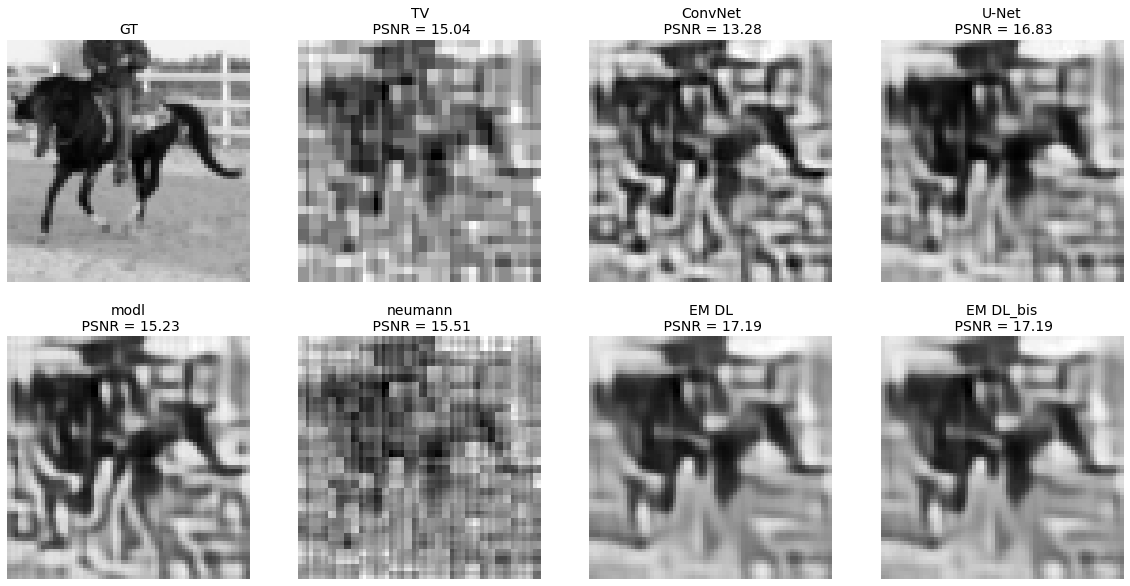

In [25]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.4] = 1.4;
    inp[inp<-1.4] = -1.4;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);
Image_1 = img_list;


### Visualizing the Outputs (test $N_0 = 5 $)

In [26]:
torch.manual_seed(2) 

N_0 = 5
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [5.00--5.00] photons
CompNet
CompNet
CompNet
CompNet


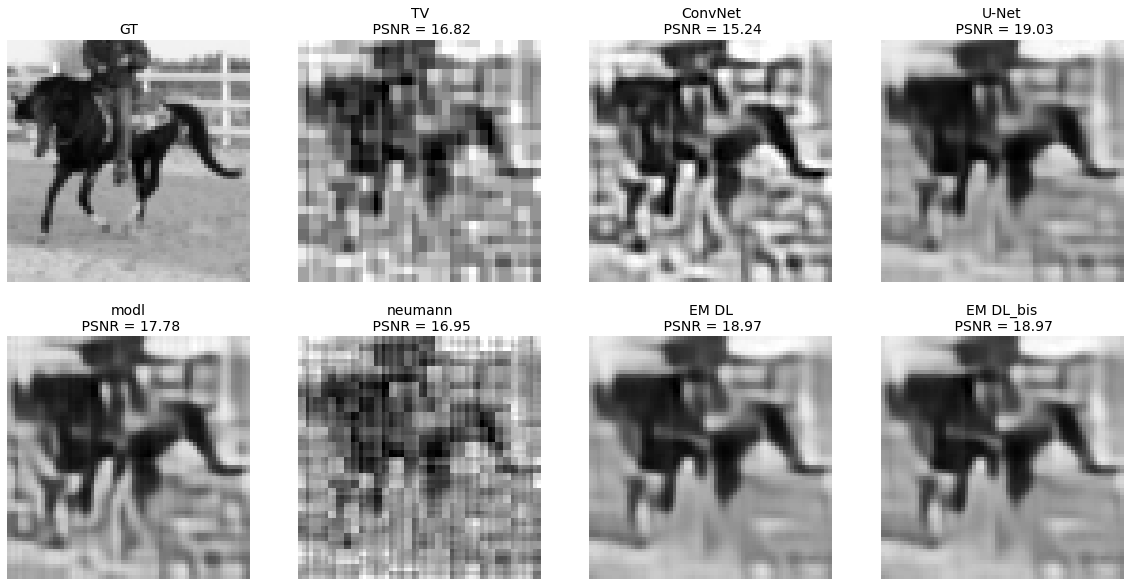

In [27]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     psnr_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);


### Visualizing the Outputs (test $N_0 = 70 $)

In [28]:
torch.manual_seed(2) 

N_0 = 70
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [70.00--70.00] photons
CompNet
CompNet
CompNet
CompNet


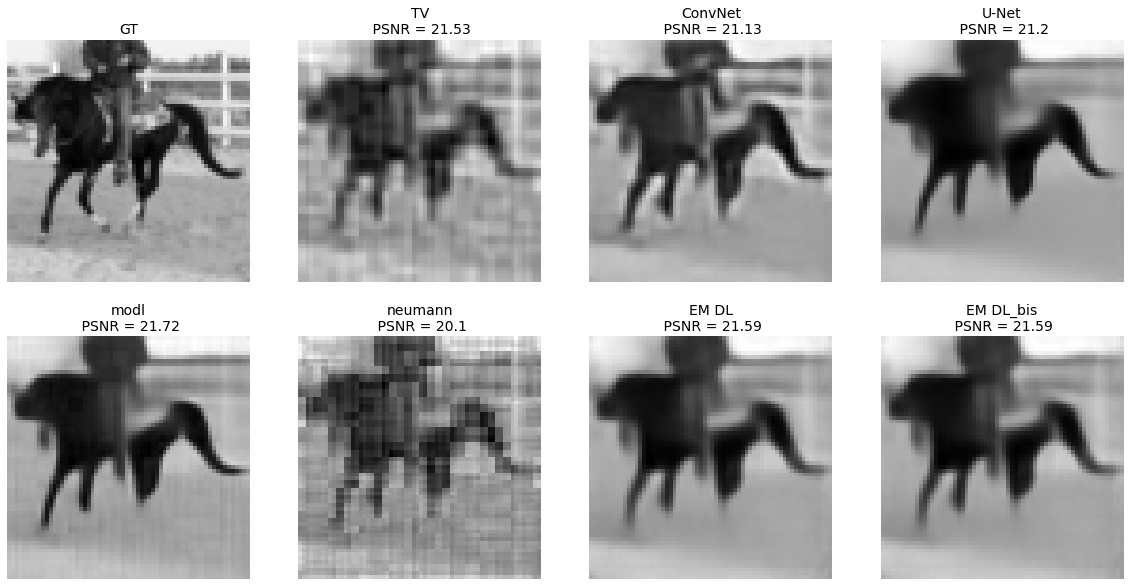

In [29]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);


## CR = 3/4, train $N_0 = 10$
### Parameters

In [30]:
CR = 1024;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

### Loading Network

In [31]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNo

In [32]:
net_arch = 2
model_root = '../../models/TCI/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_30_lr_0.001_sss_7_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_30_lr_0.001_sss_7_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [33]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False;
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_60_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride

In [34]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_4 = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()


Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_31_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [35]:
net_arch = 2
model_root = '../../models/TCI/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_5 = DConvNet();
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_100_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5),

In [36]:
net_arch = 0;
model_root = '../../models/TCI/EM_net/'
title_6 = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_6 = DConvNet();
denoi_6 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI/EM_net/DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_30_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

### Visualizing the Outputs (test $N_0 = 2 $)

In [37]:
[x, labels] = next(iter(testloader));
x = x[5,0,:,:];
x = x.to(device);
x = x.view(1,1,img_size, img_size)

In [38]:
torch.manual_seed(2) 

N_0 = 2
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [2.00--2.00] photons
CompNet
CompNet
CompNet
CompNet


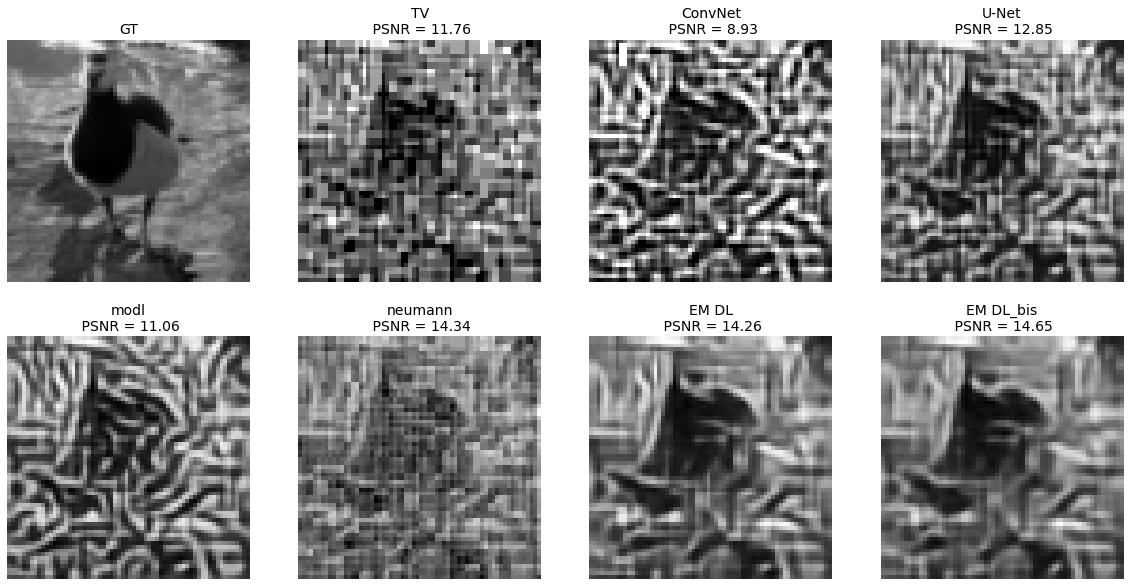

In [39]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.4] = 1.4;
    inp[inp<-1.4] = -1.4;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);


### Visualizing the Outputs (test $N_0 = 5 $)

In [40]:
torch.manual_seed(22) 

N_0 = 5
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [5.00--5.00] photons
CompNet
CompNet
CompNet
CompNet


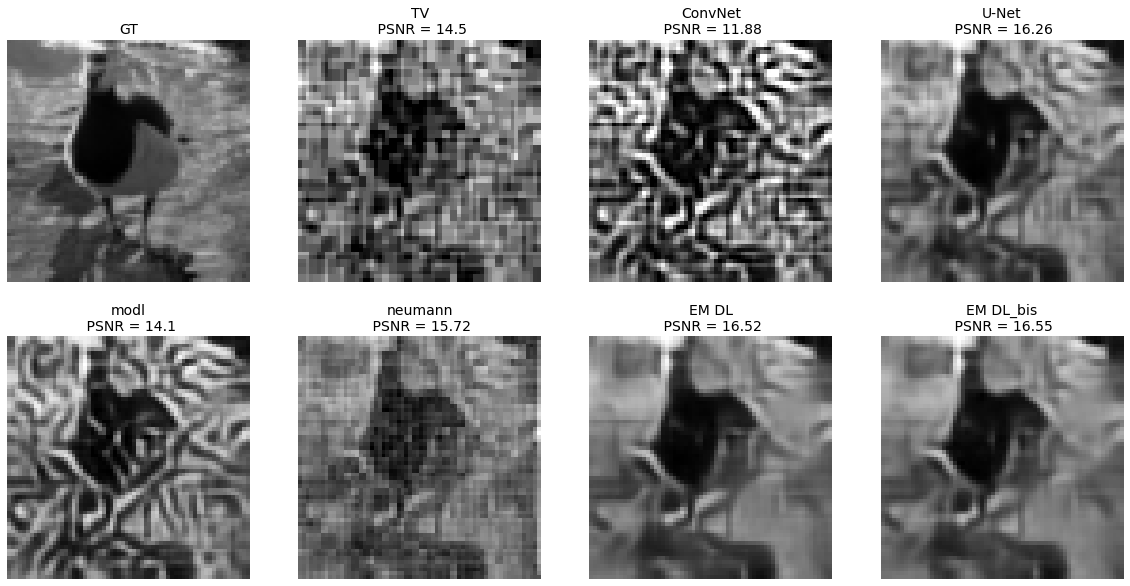

In [41]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     psnr_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);
Image_2 = img_list;



### Visualizing the Outputs (test $N_0 = 30 $)

In [42]:
torch.manual_seed(22) 

N_0 = 30
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [30.00--30.00] photons
CompNet
CompNet
CompNet
CompNet


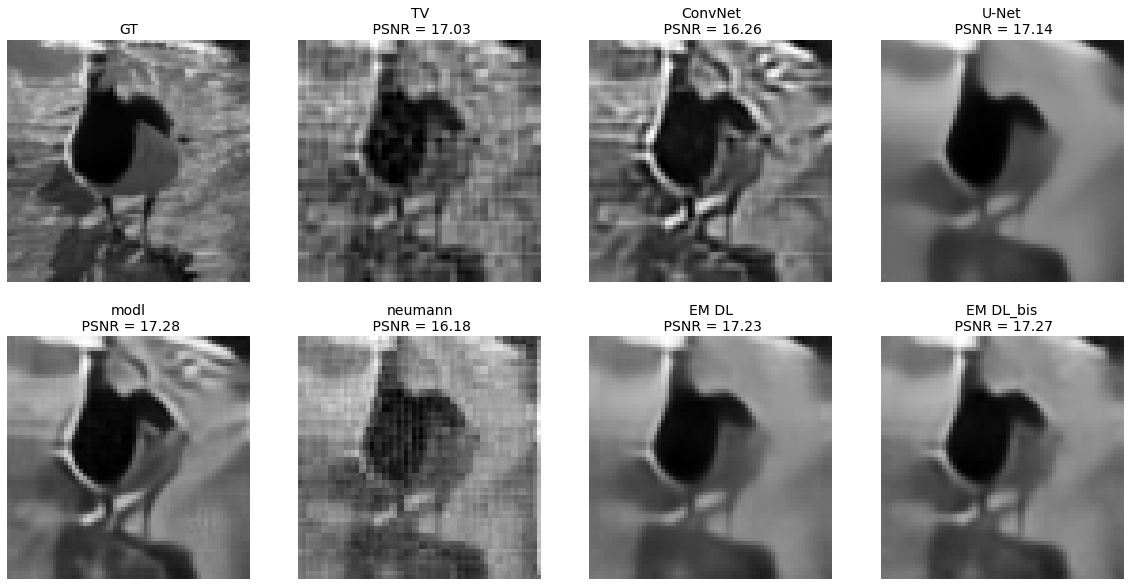

In [43]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);
Image_2 = img_list;


# Imagenet

In [44]:
from spyrit.learning.imagenet_dataset import NetImage

In [45]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

torch.manual_seed(7)

transform = transforms.Compose(
    [transforms.functional.to_grayscale,
     transforms.Resize((img_size, img_size)),
     transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5])])



trainset = \
      NetImage(root=data_root, train = True, transform=transform)
trainloader = \
    torch.utils.data.DataLoader(trainset, batch_size=batch_size,shuffle=False)
testset = \
        NetImage(root=data_root, train = False, transform=transform)
testloader = \
     torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False)

dataloaders = {'train':trainloader, 'val':testloader}
num_img = {'train' : len(trainset), 'val' : len(testset)}

## CR = 7/8, train $N_0 = 10$
### Parameters

In [46]:
CR = 512;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

### Loading Networks

In [47]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/U_net_pinv_N0_10_sig_0_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d

In [48]:
net_arch = 2
model_root = '../../models/TCI_imagenet/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_512_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 

In [49]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI_imagenet/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_20_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False; #was done during training script.
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_512_epo_20_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, 

In [50]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_4 = model_root+"DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_16_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_16_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [51]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_512_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5), str

In [52]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_6 = model_root+"DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_12_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
# model_root = '../../models/TCI/EM_net/'
# title_6 = model_root+"DConvNet_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_40_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-06"
denoi_6 = DConvNet();
denoi_6 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_6 = model_6.to(device);
load_net(title_6, model_6);
model_6.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_512_epo_12_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 512, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=512, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=512, out_features=4096, bias=False)
  (fc1): Linear(in_features=512, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


### Visualizing the Outputs (test $N_0 = 2 $)

In [53]:
[x, labels] = next(iter(testloader));
x = x[7,0,:,:]; # 6 can work
x = x.to(device);
x = x.view(1,1,img_size, img_size)

In [54]:
torch.manual_seed(2) 

N_0 = 2
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [2.00--2.00] photons
CompNet
CompNet
CompNet
CompNet


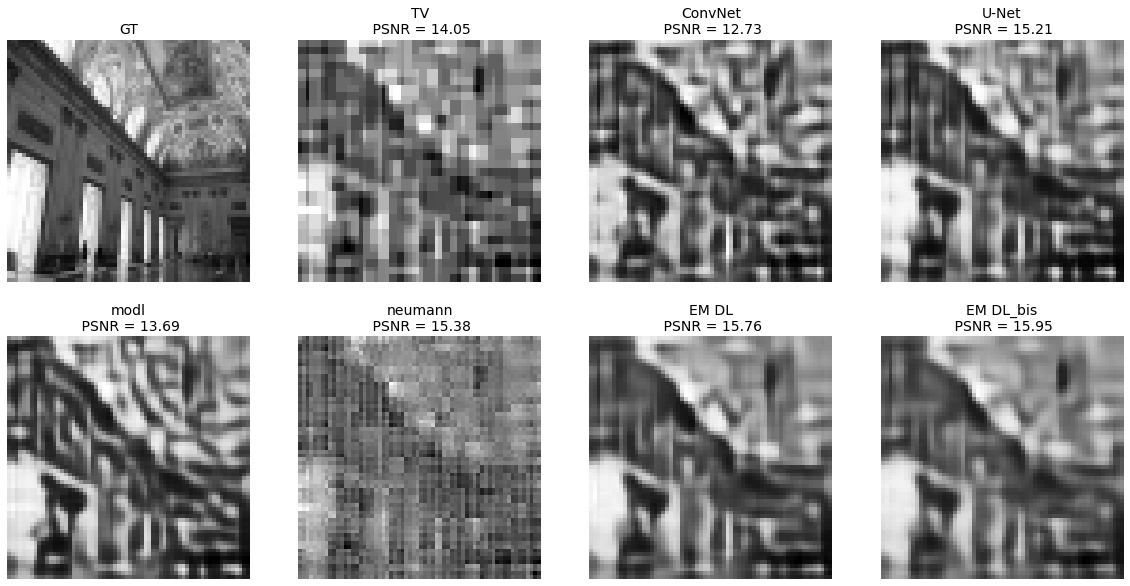

In [55]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.4] = 1.4;
    inp[inp<-1.4] = -1.4;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);
Image_3 = img_list;


### Visualizing the Outputs (test $N_0 = 5 $)

In [56]:
torch.manual_seed(22) 

N_0 = 5
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [5.00--5.00] photons
CompNet
CompNet
CompNet
CompNet


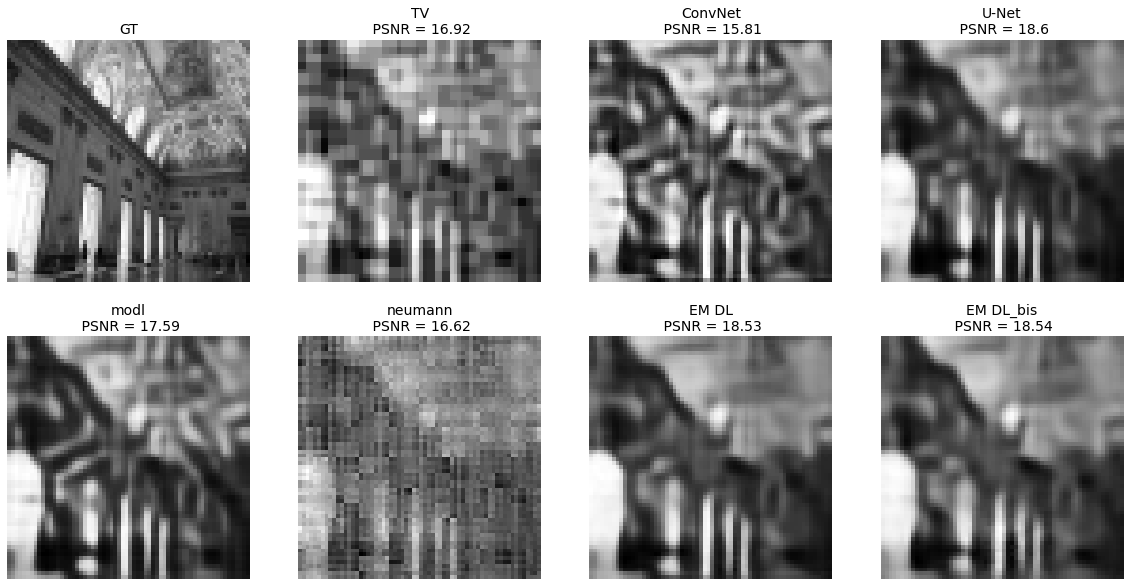

In [57]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     psnr_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);


### Visualizing the Outputs (test $N_0 = 70 $)

In [58]:
torch.manual_seed(22) 

N_0 = 20
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [20.00--20.00] photons
CompNet
CompNet
CompNet
CompNet


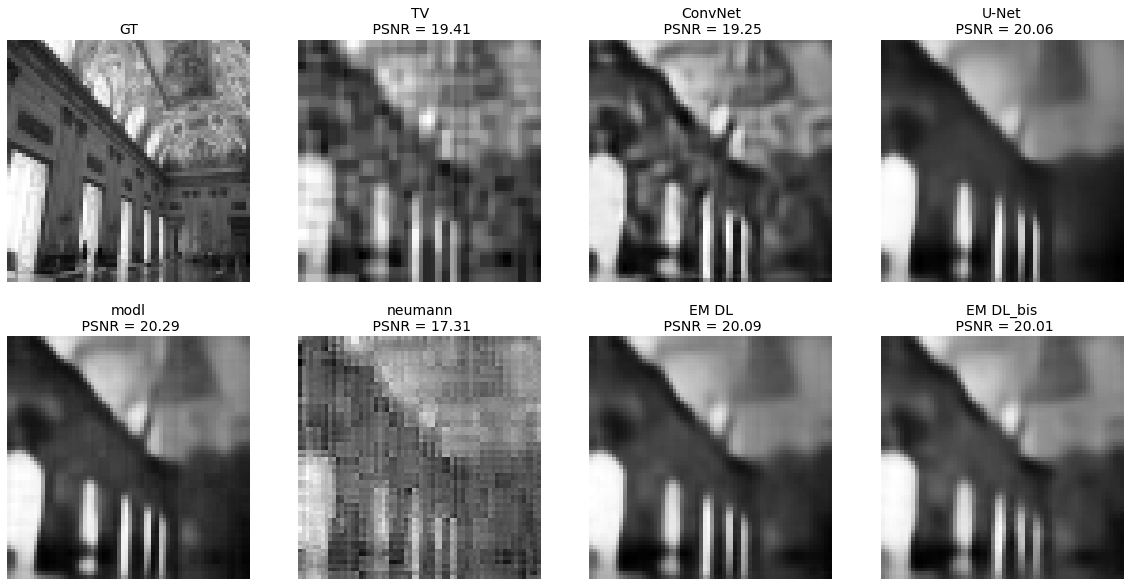

In [59]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);


## CR = 3/4, train $N_0 = 10$
### Parameters

In [60]:
CR = 1024;
N0 = 10;
# sig = 0.5;
sig = 0;


Pmat = np.dot(Perm,H);
Pmat = img_size*Pmat[:CR,:];

In [61]:
# del model_1
# del model_2
# del model_3
# del model_4
# del model_5
# del model_6
del x;
torch.cuda.empty_cache()

### Loading Network

In [62]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_1 = model_root+"U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
denoi_1 = Unet(1,1);
model_1 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_1);
model_1.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_1 = model_1.to(device);
load_net(title_1, model_1);
model_1.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/U_net_pinv_N0_10_sig_0_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): Unet(
    (conv_encode1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv_encode2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): BatchNo

In [63]:
net_arch = 2
model_root = '../../models/TCI_imagenet/modl/'
title_2 = model_root + "_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_10_lr_0.001_sss_3_sdr_0.5_bs_64_reg_1e-07"
denoi_2 = Unet(1,1);
denoi_2 = iteratif(CR, img_size, Cov_had,H, denoi_2, n_iter = n_iter)
model_2 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_2);
model_2.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_2 = model_2.to(device);
load_net(title_2, model_2);
model_2.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/modl/_pinv_N0_10_sig_0_Denoi_modl_Iteratif_4_N_64_M_1024_epo_10_lr_0.001_sss_3_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): iteratif(
    (conv): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (conv_encode2): Sequential(
        (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=

In [64]:
n_iter = 4;
net_arch = 2;
model_root = '../../models/TCI_imagenet/neumann/'
title_3 = model_root+"U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_3 = Unet(1,1);
denoi_3 = NeumannNet(CR, img_size, Cov_had, H, denoi_3, iterations = n_iter)
model_3 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_3);
model_3.recon.Gramian.weight.requires_grad = False; #was done during training script.
model_3.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_3 = model_3.to(device);
load_net(title_3, model_3);
model_3.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/neumann/U_net_u_N0_10_sig_0_neumann_4_N_64_M_1024_epo_15_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): NeumannNet(
    (Pinvtot): Conv2d(1, 4096, kernel_size=(64, 64), stride=(1, 1))
    (Gramian): Linear(in_features=4096, out_features=4096, bias=False)
    (nonlinear_op): Unet(
      (conv_encode1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): ReLU()
        (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (conv_maxpool1): MaxPool2d(kernel_size=2, stride

In [65]:
net_arch = 0;
model_root = '../../models/TCI_imagenet/EM_net/'
title_4 = model_root+"DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
denoi_4 = DConvNet();
denoi_4 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_4, n_iter = n_iter)
model_4 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_4);
model_4.recon.completion_layer.weight.requires_grad = False;
model_4.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_4 = model_4.to(device);
load_net(title_4, model_4);
model_4.eval()

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Denoised Measurements
Model Loaded: ../../models/TCI_imagenet/EM_net/DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07


DenoiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): sn_dp_iteratif_2(
    (conv): DConvNet(
      (convnet): Sequential(
        (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
        (relu1): ReLU()
        (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (relu2): ReLU()
        (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (relu3): ReLU()
        (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tr

In [66]:
net_arch = 2
model_root = '../../models/TCI_imagenet/Unet/'; #  Path to model saving files
title_5 = model_root+"DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07"
model_5 = noiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_5);
model_5.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
model_5 = model_5.to(device);
load_net(title_5, model_5);
model_5.eval()

Measurement to image domain: pseudo inverse
Varying N0 = 10 +/- 0
Model Loaded: ../../models/TCI_imagenet/Unet/DCONV_pinv_N0_10_sig_0_Denoi_N_64_M_1024_epo_50_lr_0.001_sss_10_sdr_0.5_bs_64_reg_1e-07


noiCompNet(
  (Patt): Conv2d(1, 1024, kernel_size=(64, 64), stride=(1, 1))
  (P): Conv2d(1, 2048, kernel_size=(64, 64), stride=(1, 1))
  (Pinv): Linear(in_features=1024, out_features=4096, bias=False)
  (Pnorm): Linear(in_features=1024, out_features=4096, bias=False)
  (fc1): Linear(in_features=1024, out_features=4096, bias=False)
  (recon): DConvNet(
    (convnet): Sequential(
      (conv1): Conv2d(1, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
      (relu1): ReLU()
      (BN1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (relu2): ReLU()
      (BN2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu3): ReLU()
      (BN3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv4): Conv2d(32, 1, kernel_size=(5, 5),

In [67]:
model_6 = model_4
# net_arch = 0;
# model_root = '../../models/TCI_imagenet/EM_net/'
# title_6 = model_root+"DCONV_c0mp_N0_10_sig_0_Denoi_Iteratif_sc_4_N_64_M_1024_epo_11_lr_0.001_sss_4_sdr_0.5_bs_64_reg_1e-07"
# denoi_6 = DConvNet();
# denoi_6 = sn_dp_iteratif_2(CR, img_size, Cov_had,H, denoi_6, n_iter = n_iter)
# model_6 = DenoiCompNet(img_size, CR, Mean_had, Cov_had, net_arch, N0, sig, H, denoi=denoi_6);
# model_6.recon.completion_layer.weight.requires_grad = False;
# model_6.Pinv.weight.requires_grad = False; # Pinv isn't used for training or testing, so it has no impact anyway.
# model_6 = model_6.to(device);
# load_net(title_6, model_6);
# model_6.eval()

### Visualizing the Outputs (test $N_0 = 2 $)

In [68]:
[x, labels] = next(iter(testloader));
x = x[0,0,:,:];
x = x.to(device);
x = x.view(1,1,img_size, img_size)

In [69]:
torch.manual_seed(2) 

N_0 = 2
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
# model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [2.00--2.00] photons
CompNet
CompNet
CompNet
CompNet


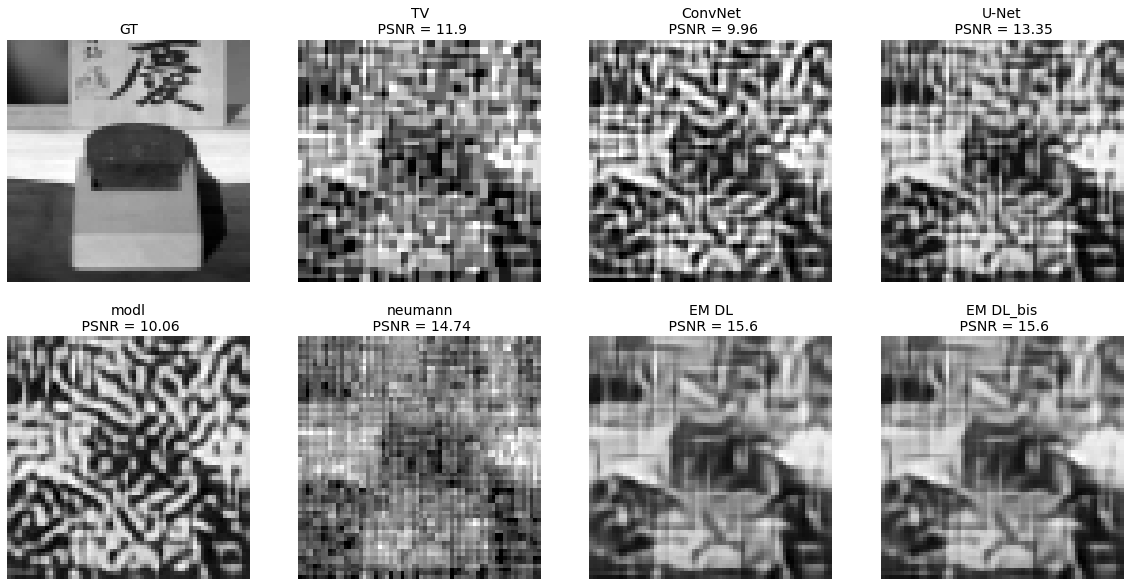

In [70]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.4] = 1.4;
    inp[inp<-1.4] = -1.4;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);


### Visualizing the Outputs (test $N_0 = 5 $)

In [71]:
torch.manual_seed(2) 

N_0 = 5
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [5.00--5.00] photons
CompNet
CompNet
CompNet
CompNet


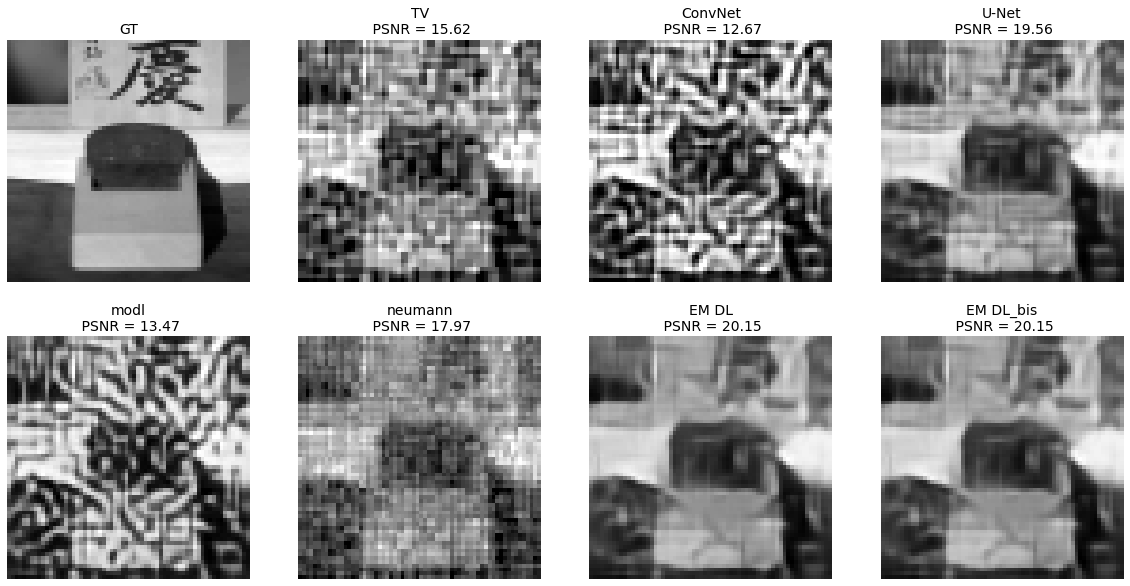

In [72]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):
    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     psnr_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);
Image_4 = img_list;

### Visualizing the Outputs (test $N_0 = 70 $)

In [73]:
torch.manual_seed(4) 

N_0 = 70
model_1.N0 = N_0;
model_2.N0 = N_0;
model_3.N0 = N_0;
model_4.N0 = N_0;
model_5.N0 = N_0;
model_6.N0 = N_0;

img_list = [];
img_list.append(torch2numpy(x.view(img_size, img_size)));
with torch.no_grad():
    m = model_1.forward_acquire(x,1, 1, img_size, img_size);
    
#     t0_start = perf_counter() 
    x_TV = batch_TV(m, 1, 1, img_size, Pmat, N_0, mu = 1, lamda = [0.005, 0.005]);
    img_list.append(torch2numpy(x_TV.view(img_size, img_size)));
#     t0_stop = perf_counter() 
#     print("TV time = {}s".format(t0_stop-t0_start))
    
    x_conv = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_conv.view(img_size, img_size)));
    
#     t1_start = perf_counter();
    x_unet = model_1.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_unet.view(img_size, img_size)));
#     t1_stop = perf_counter();
#     print("UNET time = {}s".format(t1_stop-t1_start))
    
    x_modl = model_2.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_modl.view(img_size, img_size)));
    
    x_neu = model_3.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_neu.view(img_size, img_size)));
    
#     t4_start = perf_counter()
    x_em = model_4.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em.view(img_size, img_size)));
#     t4_stop = perf_counter();
#     print("EM-NET time = {}s".format(t4_stop-t4_start))

    x_em_bis = model_6.forward_reconstruct(m, 1, 1, img_size, img_size);
    img_list.append(torch2numpy(x_em_bis.view(img_size, img_size)));
    
#     x_em_nc = model_5.forward_reconstruct(m, 1, 1, img_size, img_size);
#     img_list.append(torch2numpy(x_em_nc.view(img_size, img_size)));

alpha in [70.00--70.00] photons
CompNet
CompNet
CompNet
CompNet


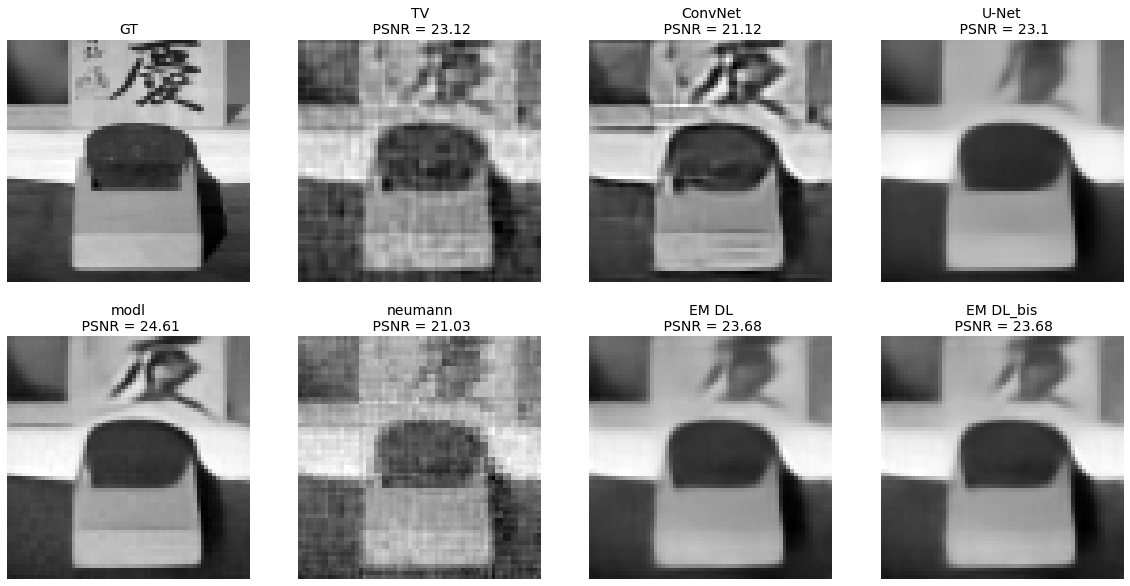

In [74]:
title_list = ["GT", "TV", "ConvNet" ,"U-Net", "modl", "neumann", "EM DL", "EM DL_bis"]
inputs = img_list[0]
#title = ["GT"];

for i in range(len(img_list)-1):    
    inp =  img_list[i+1];
    inp[inp>1.1] = 1.1;
    inp[inp<-1.1] = -1.1;
    img_list[i+1]= inp;
    
    

    
for i in range(len(img_list)-1):
    output = (img_list[i+1]-np.mean(img_list[i+1]));
#     output = img_list[i+1];
    psnr_1 = round(psnr(inputs, output),2);
#     ssim_1 = round(ssim(inputs,output),2);
    #title.append(" {} : {} PSNR = {}, SSIM = {}".format(title_list[i+1] ,round(psnr_1,2),round(ssim_1,2)) );
#     title_list[i+1]+= "\n PSNR = {} \n SSIM = {}".format(psnr_1, ssim_1);
    title_list[i+1] += "\n PSNR = {}".format(psnr_1);

plt.ion();
Multi_plots(img_list, title_list, [2,4]);
# Image_3 = img_list;

# Final Figure on simulated data

In [75]:
image1 = np.stack(Image_1, axis = 0);
image2 = np.stack(Image_2, axis = 0);
image3 = np.stack(Image_3, axis = 0);
image4 = np.stack(Image_4, axis = 0);
image1 = np.reshape(image1, (1,8,1,img_size, img_size))
image2 = np.reshape(image2, (1,8,1,img_size, img_size))
image3 = np.reshape(image3, (1,8,1,img_size, img_size))
image4 = np.reshape(image4, (1,8,1,img_size, img_size))
Images = [image1, image2, image3, image4]

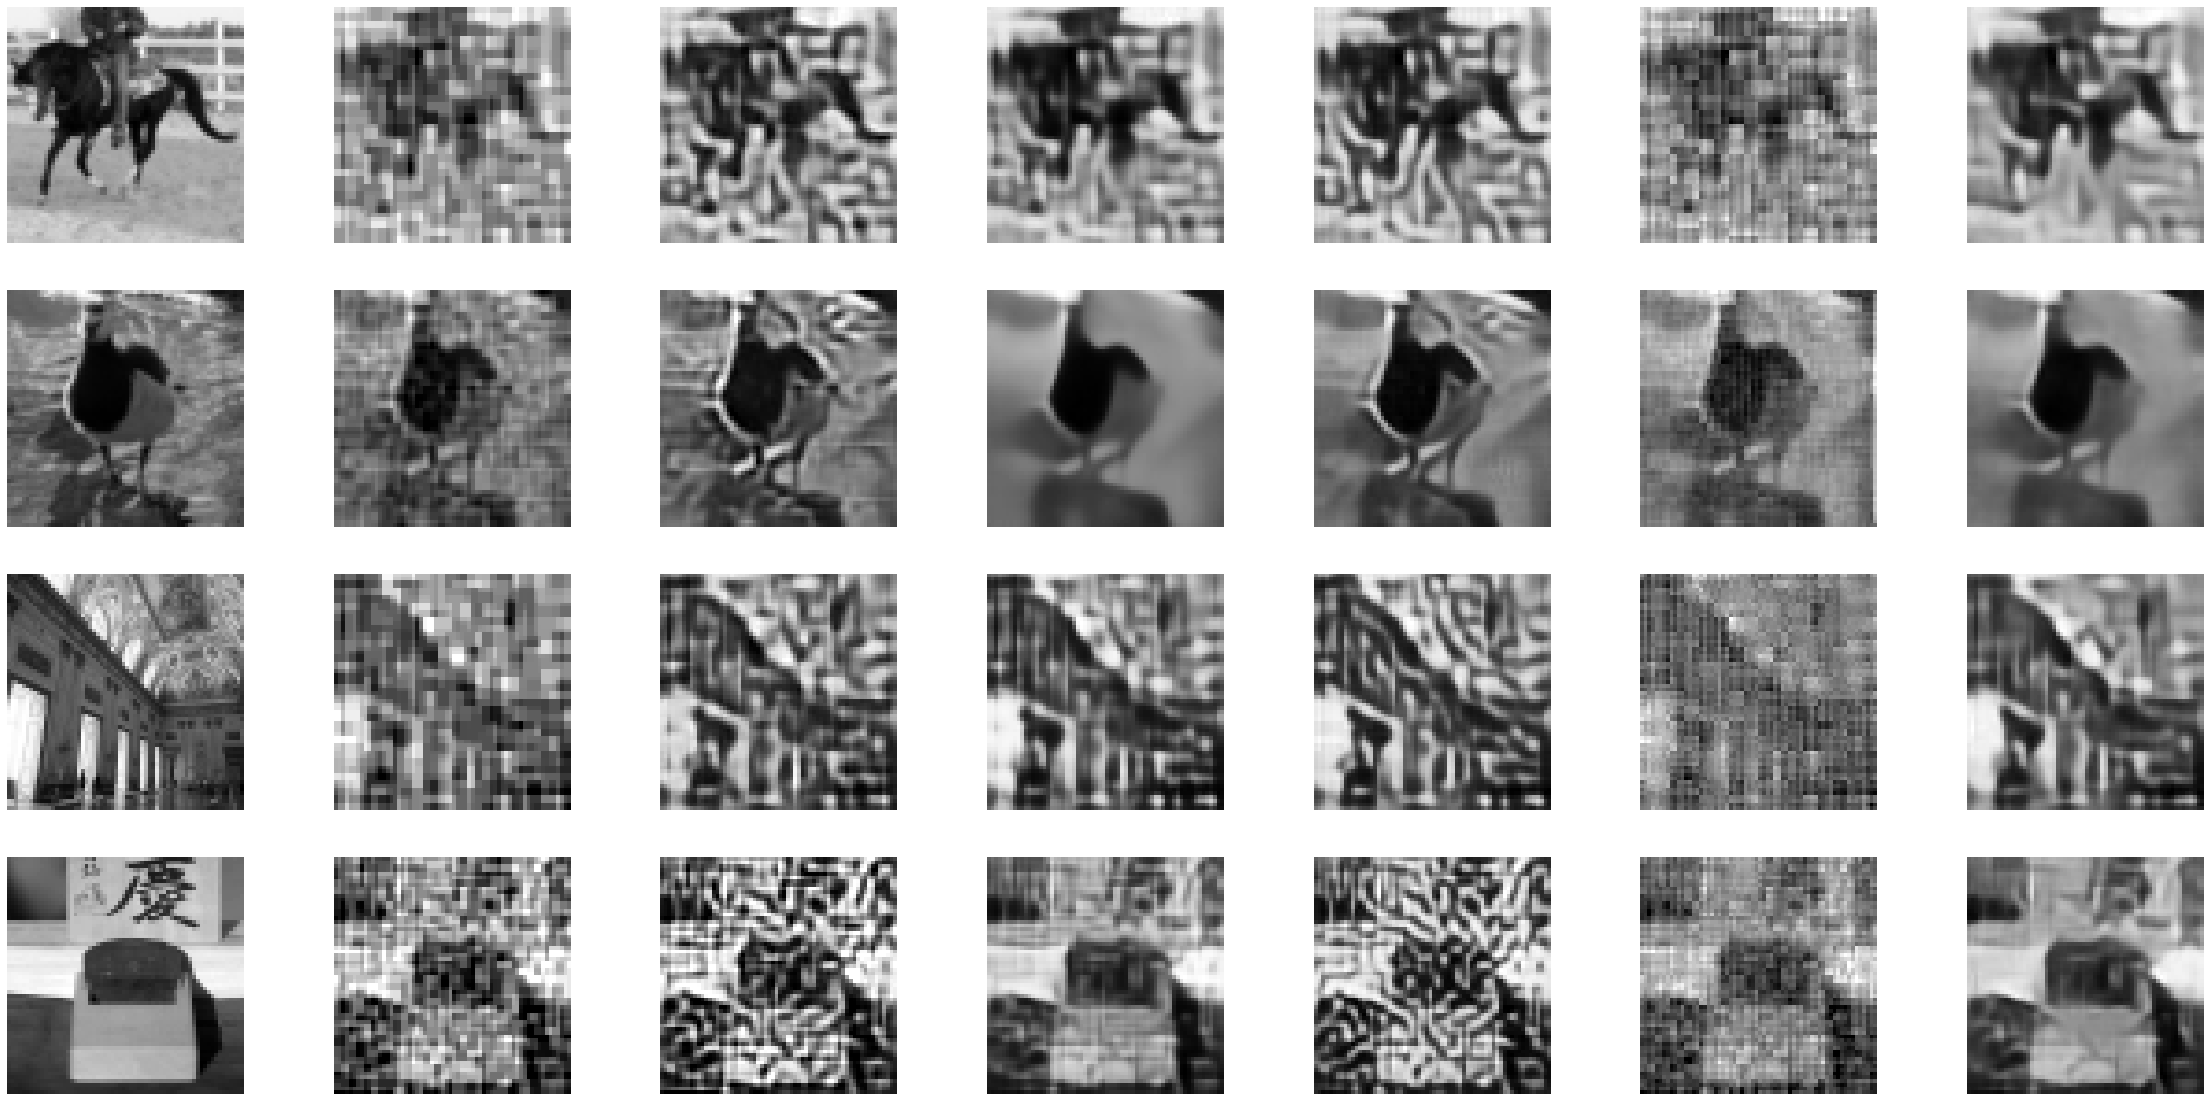

In [76]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
plt.rcParams['pdf.fonttype'] = 42
nb_disp_frames = 7;
titles = [["" for i in range(8)] for j in range(4)]
compare_video_frames(Images, nb_disp_frames,titles, aspect = (40,20) ,savefig = 'img/simulated_images.pdf');
# compare_video_frames(outputs, nb_disp_frames, title_lists, aspect = (10,4) ,savefig = '../../img/isbi_2021/results_expe.pdf', fontsize = 12)
# compare_video_frames(outputs, nb_disp_frames, title_lists, aspect = (40,20) ,savefig = 'img/simulated_images.pdf', fontsize = 40)